## Setting Up the Libs and Overthurst Configurations

In [1]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 5.                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = 30.0                  # step interval along x/z direction
dx1        = 30.0                  # step interval along y/z direction

dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 94                   # model shape of z dimension (depth) overthrust
ny        = 400                   # model shape of y dimension overthrust
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 30                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 567        # number of receivers per shot
source_spacing = np.floor(dx * ny / (num_shots+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx1 * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 0                # the index depth of sources, default is 0
receiver_depth = 0              # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [0,10,10,10,0,0]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

fwi_lr            = 20        # learning rate for updating the model.
fwi_batch         =   30      # number of batches for FWI.
fwi_num_epochs    = 600       # number of FWI iteration.
sim_lr            = 1*1e-5    # learning rate for Soamese network.
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations


/home/sadalyom/.conda/envs/FWIGAN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##   Check Cuda Device 


In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Creating Data Pathes

In [3]:
 
data_path = 'data/over_94_400.bin'
initfile = 'data/over_initmodel.mat'
initsafile = 'data/over_initsource.mat'
fwi_result = 'results/overthrustfwi/'

# Loading the true model
model_true = loadtruemodel(data_path, num_dims, vmodel_dim).to(device)
model, model_init = loadinitmodel(initfile,device)
# The model will be updated during FWI
model = torch.nn.Parameter(model)
# Creating source and reciver locations
x_s, x_r = createSR(num_shots, num_sources_per_shot, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s, x_r = x_s.to(device), x_r.to(device)
# Source Amplitude
source_amplitudes_init, source_amplitudes_true = loadinitsource(initsafile,device)
source = source_amplitudes_init.repeat(1,num_shots, num_sources_per_shot)
# receiver Amplitude
receiver_amplitudes = createdata(model_true,dx,source, \
                                x_s,x_r,dt,pml_width,order, \
                                 survey_pad,device).to(device)
receiver_amplitudes_true = receiver_amplitudes
rcv_amps_true = receiver_amplitudes_true.clone()

## Plotting the inital and true model


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


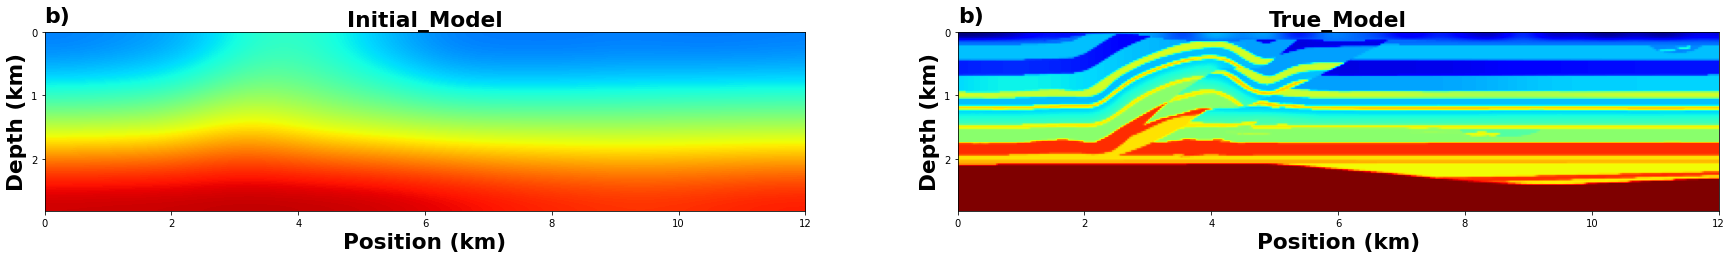

In [4]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3])
box_min = 2360
box_max = 6000

f, ax = plt.subplots(1,2,figsize=(30, 13))
plt.rc('font', **font)


im = ax[0].imshow(model_init, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model_init.shape[1] * dx / 1000, model_init.shape[0] * dx1 / 1000, 0])
ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'b)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

model1 = model_true.detach().cpu().numpy()
im = ax[1].imshow(model1, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model1.shape[1] * dx / 1000, model1.shape[0] * dx1 / 1000, 0])
ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('True_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 


plt.show()

## Setting Up the Siamese and Optimizers

In [5]:
from torchsummary import summary
from Model.Module22_6 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 1/2


### optimizer for the velocity model
optimizer = optim.Adam([{'params': model, 'lr':fwi_lr, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

#summary(netD,[(nt,1,num_receivers_per_shot),(nt,1,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0




Number of netD params: 1519


## Main SiameseFWI

In [6]:
 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR
import torch.fft






t_start = time.time()
model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
                                          order,survey_pad)
        batch_src_amps = source_amplitudes_init.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true[:,it::fwi_batch].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)

        # R, I, and A for simulated and observed data
        d_real = batch_rcv_amps_true[:,0,:]
        d_real_f = torch.fft.fft(d_real, dim=0)
        d_abs = torch.abs(d_real_f)
        d_abs = torch.cat([d_abs[0:400,:],d_abs[-400:,:]])
        #d_abs = d_abs.permute(1,0)
        d_abs = d_abs.unsqueeze(0).unsqueeze(0)
        
        d_real_r = torch.real(d_real_f)
        d_real_r = torch.cat([d_real_r[0:400,:],d_real_r[-400:,:]])
        #d_real_r = d_real_r.permute(1,0)
        d_real_r = d_real_r.unsqueeze(0).unsqueeze(0)
        
        d_real_i = torch.imag(d_real_f)
        d_real_i = torch.cat([d_real_i[0:400,:],d_real_i[-400:,:]])
        #d_real_i = d_real_i.permute(1,0)
        d_real_i = d_real_i.unsqueeze(0).unsqueeze(0)
        d_real_inp = torch.cat([d_real_r,d_real_i,d_abs],axis=1)


        d_fake = batch_rcv_amps_pred[:,0,:]       
        d_fake_f = torch.fft.fft(d_fake, dim=0)
        d_abs_f = torch.abs(d_fake_f)
        d_abs_f = torch.cat([d_abs_f[0:400,:],d_abs_f[-400:,:]])
        #d_abs_f = d_abs_f.permute(1,0)
        d_abs_f = d_abs_f.unsqueeze(0).unsqueeze(0)
        
        d_fake_r = (torch.real(d_fake_f))
        d_fake_r = torch.cat([d_fake_r[0:400,:],d_fake_r[-400:,:]])
        #d_fake_r = d_fake_r.permute(1,0)
        d_fake_r = d_fake_r.unsqueeze(0).unsqueeze(0)

        d_fake_i = (torch.imag(d_fake_f))
        d_fake_i = torch.cat([d_fake_i[0:400,:],d_fake_i[-400:,:]])
        #d_fake_i = d_fake_i.permute(1,0)
        d_fake_i = d_fake_i.unsqueeze(0).unsqueeze(0)
        d_fake_inp = torch.cat([d_fake_r,d_fake_i,d_abs_f],axis=1)
        
        disc_fake, disc_real, o1, o2 = netD(d_real_inp,d_fake_inp)
        loss = 0.3*F.pairwise_distance(o1[0,0,:,:],o2[0,0,:,:], keepdim = True).mean() + 0.3*F.pairwise_distance(o1[0,1,:,:],o2[0,1,:,:], keepdim = True).mean()+ 0.4*F.pairwise_distance(o1[0,2,:,:],o2[0,2,:,:], keepdim = True).mean()

        
        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model.data=torch.clamp(model.data,min=1e-12)


    # Update the learning rate each 200 FWI iterations .
    if (i>0) and (i%200==0):
        scheduler.step()
        
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizer.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model.detach().cpu().numpy(),  
              model_true.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERec_.mat', \
                         {'rec':model.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 

# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 



Epoch: 1 Loss:  244.94962412516276 lr_DL: 1e-05 lr_vel: 20 SNR: 18.93191853792194 SSIM: 0.09869997
Epoch: 2 Loss:  212.4056838989258 lr_DL: 1e-05 lr_vel: 20 SNR: 18.224253667218413 SSIM: 0.043521043
Epoch: 3 Loss:  184.15589752197266 lr_DL: 1e-05 lr_vel: 20 SNR: 17.83511116445949 SSIM: 0.04185765
Epoch: 4 Loss:  164.90142822265625 lr_DL: 1e-05 lr_vel: 20 SNR: 17.58590822397554 SSIM: 0.054119997
Epoch: 5 Loss:  154.3898701985677 lr_DL: 1e-05 lr_vel: 20 SNR: 17.419270430079003 SSIM: 0.06572611
Epoch: 6 Loss:  146.37786102294922 lr_DL: 1e-05 lr_vel: 20 SNR: 17.320970694587263 SSIM: 0.078314565
Epoch: 7 Loss:  140.37535858154297 lr_DL: 1e-05 lr_vel: 20 SNR: 17.262996103556798 SSIM: 0.09085616
Epoch: 8 Loss:  135.4393081665039 lr_DL: 1e-05 lr_vel: 20 SNR: 17.22877040915751 SSIM: 0.103091545
Epoch: 9 Loss:  132.17476577758788 lr_DL: 1e-05 lr_vel: 20 SNR: 17.216055994728674 SSIM: 0.1153767
Epoch: 10 Loss:  129.5794687906901 lr_DL: 1e-05 lr_vel: 20 SNR: 17.210083494911803 SSIM: 0.1268401
Epoch

Epoch: 84 Loss:  47.229843330383304 lr_DL: 1e-05 lr_vel: 20 SNR: 18.99840515800416 SSIM: 0.44045514
Epoch: 85 Loss:  45.184882672627765 lr_DL: 1e-05 lr_vel: 20 SNR: 19.049340575704864 SSIM: 0.44307747
Epoch: 86 Loss:  45.5778990427653 lr_DL: 1e-05 lr_vel: 20 SNR: 19.08159526889895 SSIM: 0.44393107
Epoch: 87 Loss:  44.35703239440918 lr_DL: 1e-05 lr_vel: 20 SNR: 19.134920403238638 SSIM: 0.44674915
Epoch: 88 Loss:  44.0101952234904 lr_DL: 1e-05 lr_vel: 20 SNR: 19.17005675989689 SSIM: 0.4475933
Epoch: 89 Loss:  42.855979919433594 lr_DL: 1e-05 lr_vel: 20 SNR: 19.22019643338325 SSIM: 0.45073745
Epoch: 90 Loss:  43.049998664855956 lr_DL: 1e-05 lr_vel: 20 SNR: 19.26048174231034 SSIM: 0.45140994
Epoch: 91 Loss:  40.68482265472412 lr_DL: 1e-05 lr_vel: 20 SNR: 19.318012110538756 SSIM: 0.4548544
Epoch: 92 Loss:  41.025685691833495 lr_DL: 1e-05 lr_vel: 20 SNR: 19.368935453851744 SSIM: 0.45626757
Epoch: 93 Loss:  40.68135903676351 lr_DL: 1e-05 lr_vel: 20 SNR: 19.42727470098424 SSIM: 0.4588049
Epoch:

Epoch: 166 Loss:  12.658422136306763 lr_DL: 1e-05 lr_vel: 20 SNR: 26.347014908230094 SSIM: 0.68887717
Epoch: 167 Loss:  12.964227978388468 lr_DL: 1e-05 lr_vel: 20 SNR: 26.3832254864911 SSIM: 0.69004107
Epoch: 168 Loss:  12.592084900538127 lr_DL: 1e-05 lr_vel: 20 SNR: 26.426238404074706 SSIM: 0.6905176
Epoch: 169 Loss:  12.881885290145874 lr_DL: 1e-05 lr_vel: 20 SNR: 26.452316346327258 SSIM: 0.6916556
Epoch: 170 Loss:  12.529792833328248 lr_DL: 1e-05 lr_vel: 20 SNR: 26.497302201161045 SSIM: 0.6920687
Epoch: 171 Loss:  12.828670152028401 lr_DL: 1e-05 lr_vel: 20 SNR: 26.52496779978733 SSIM: 0.6931999
Epoch: 172 Loss:  12.46447172164917 lr_DL: 1e-05 lr_vel: 20 SNR: 26.565486382150883 SSIM: 0.69356257
Epoch: 173 Loss:  12.73728249867757 lr_DL: 1e-05 lr_vel: 20 SNR: 26.592270054880444 SSIM: 0.6946233
Epoch: 174 Loss:  12.341992505391438 lr_DL: 1e-05 lr_vel: 20 SNR: 26.630927661307055 SSIM: 0.6949752
Epoch: 175 Loss:  12.558625666300456 lr_DL: 1e-05 lr_vel: 20 SNR: 26.66039196804027 SSIM: 0.6

Epoch: 247 Loss:  5.263252329826355 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.41545156210193 SSIM: 0.73061365
Epoch: 248 Loss:  5.348122231165568 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.432148564501915 SSIM: 0.7309719
Epoch: 249 Loss:  5.236702116330465 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.449330926154893 SSIM: 0.73126525
Epoch: 250 Loss:  5.318754061063131 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.465128242839487 SSIM: 0.73158544
Epoch: 251 Loss:  5.201389853159586 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.48248402293008 SSIM: 0.7318715
Epoch: 252 Loss:  5.286278518040975 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.497328669068263 SSIM: 0.7322291
Epoch: 253 Loss:  5.172184952100118 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.513699976624984 SSIM: 0.7325172
Epoch: 254 Loss:  5.251570860544841 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.529040964662382 SSIM: 0.732872
Epoch: 255 Loss:  5.135002589225769 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.544195889380713 SSIM: 0.73310995
Epoch: 256 Loss:  5.219720005989075 lr_DL: 1e-05 lr_vel: 10.0 SNR: 28.55890491610

Epoch: 328 Loss:  4.020985595385233 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.44173810558828 SSIM: 0.75293714
Epoch: 329 Loss:  4.035284201304118 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.457511146287633 SSIM: 0.7531695
Epoch: 330 Loss:  3.9551642417907713 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.462575342253835 SSIM: 0.75346565
Epoch: 331 Loss:  4.014435410499573 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.479305076208643 SSIM: 0.75367
Epoch: 332 Loss:  3.923528226216634 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.484392133252616 SSIM: 0.75397265
Epoch: 333 Loss:  3.993970537185669 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.500929393128196 SSIM: 0.75417346
Epoch: 334 Loss:  3.894806965192159 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.50606236258389 SSIM: 0.75448173
Epoch: 335 Loss:  3.9488673289616902 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.522037980979874 SSIM: 0.75470847
Epoch: 336 Loss:  3.881087005138397 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.5270051261261 SSIM: 0.7550337
Epoch: 337 Loss:  3.9154876470565796 lr_DL: 1e-05 lr_vel: 10.0 SNR: 29.543776172

Epoch: 408 Loss:  1.5113812943299612 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.331656175248195 SSIM: 0.77551425
Epoch: 409 Loss:  1.555467148621877 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.34433574962459 SSIM: 0.7756223
Epoch: 410 Loss:  1.5067370076974234 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.351386388456802 SSIM: 0.77589947
Epoch: 411 Loss:  1.5187864979108174 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.364597783662756 SSIM: 0.776054
Epoch: 412 Loss:  1.4670217037200928 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.372198916393856 SSIM: 0.7763197
Epoch: 413 Loss:  1.4864636878172557 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.385276756629946 SSIM: 0.77648944
Epoch: 414 Loss:  1.4515551328659058 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.39247531987439 SSIM: 0.77675647
Epoch: 415 Loss:  1.4668435831864675 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.405755079998645 SSIM: 0.77690876
Epoch: 416 Loss:  1.4313481370608012 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.413241531870277 SSIM: 0.7771714
Epoch: 417 Loss:  1.4547410507996876 lr_DL: 1e-05 lr_vel: 5.0 SNR: 30.42632911249

Epoch: 489 Loss:  0.950492658217748 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.23690272488668 SSIM: 0.79467434
Epoch: 490 Loss:  1.0191028813521068 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.24289860978076 SSIM: 0.7951115
Epoch: 491 Loss:  1.045887549718221 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.262086813185014 SSIM: 0.795378
Epoch: 492 Loss:  1.032408106327057 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.266173006840837 SSIM: 0.7955944
Epoch: 493 Loss:  1.0229604462782542 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.288210854248284 SSIM: 0.79591125
Epoch: 494 Loss:  1.0144761145114898 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.290278176192455 SSIM: 0.79608107
Epoch: 495 Loss:  1.0148163874944052 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.31315433025735 SSIM: 0.79643524
Epoch: 496 Loss:  0.958706816037496 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.32124979005633 SSIM: 0.796494
Epoch: 497 Loss:  0.9070689797401428 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.335623809721746 SSIM: 0.7968466
Epoch: 498 Loss:  0.9387043277422588 lr_DL: 1e-05 lr_vel: 5.0 SNR: 31.34256364605056 SSI

Epoch: 570 Loss:  0.8110404809316 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.3538266800343 SSIM: 0.81688064
Epoch: 571 Loss:  0.7997663795948029 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.379103042332375 SSIM: 0.81711686
Epoch: 572 Loss:  0.8168650547663371 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.383594743075314 SSIM: 0.81738615
Epoch: 573 Loss:  0.8097660322984059 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.40511932735118 SSIM: 0.81764203
Epoch: 574 Loss:  0.786253081758817 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.41145697737548 SSIM: 0.8179399
Epoch: 575 Loss:  0.7503445148468018 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.429645787450795 SSIM: 0.8182371
Epoch: 576 Loss:  0.7848686287800472 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.44624313052018 SSIM: 0.81843185
Epoch: 577 Loss:  0.7995782325665156 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.46198751779219 SSIM: 0.8187174
Epoch: 578 Loss:  0.7878295024236043 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.4702757478235 SSIM: 0.81905115
Epoch: 579 Loss:  0.8034498323996861 lr_DL: 1e-05 lr_vel: 5.0 SNR: 32.49205921290089 SSI

## Plotting the Reconstructed Velocity Model

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


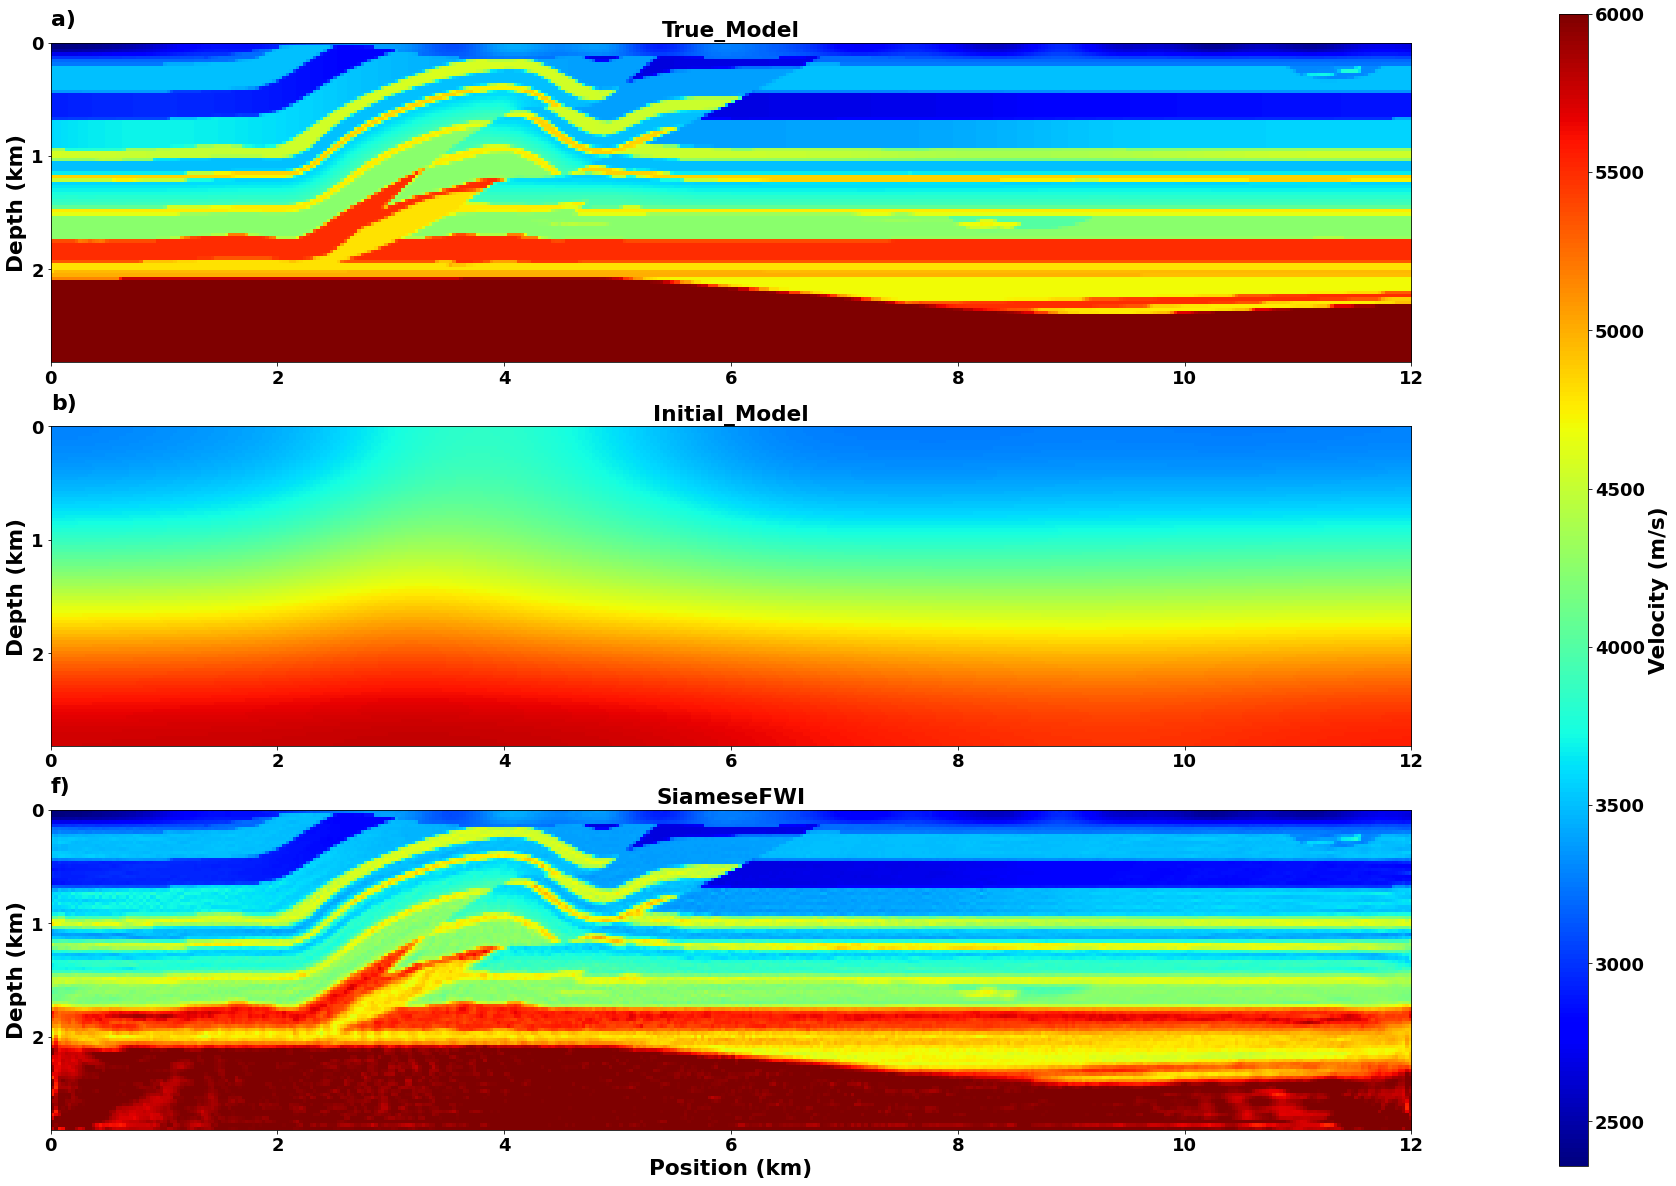

The reconstructed velocity model has SNR: 32.78973388845208 dB and SSIM: 0.8246385


In [9]:

f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model1
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx / 1000, modeltrue.shape[0] * dx1 / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx1 / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERec_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx1 / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))